In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_methods_regions(results_mae_map, methods = ["Transformer-LSP", "Prithvi-Pretraining", "Prithvi-Pretraining-Freeze"]):
    # === Load tile geometries ===
    geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
    geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})
    geo_data["HLStile"] = "T" + geo_data["name"]
    geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
    geo_data["centroid"] = geo_data.geometry.centroid

    # === Load ecoregion shapefile ===
    eco_path = "useco1/NA_CEC_Eco_Level1.shp"  # Update this path
    eco_gdf = gpd.read_file(eco_path).to_crs(geo_data.crs)  # project to match tile centroids

    mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]


    # === Prepare GeoDataFrame of result centroids ===
    results_df = mae_filtered.copy()
    results_df = results_df[["HLStile", "SiteID", "Method", "MAE"]]
    results_df = results_df.merge(
        geo_data[["HLStile", "SiteID", "centroid"]],
        on=["HLStile", "SiteID"],
        how="left"
    )
    results_gdf = gpd.GeoDataFrame(results_df, geometry="centroid", crs=geo_data.crs)
    results_gdf = results_gdf.dropna(subset=["centroid"])  # drop unmatched rows

    # === Spatial join: assign each result to an ecoregion ===
    results_with_region = gpd.sjoin(results_gdf, eco_gdf, how="inner", predicate="intersects")

    # === Choose desired region level ===
    region_column = "NA_L1NAME"  # or US_L1NAME or US_L3NAME for more/fewer regions

    # === Group by region and method ===
    region_method_mae = (
        results_with_region.groupby([region_column, "Method"])["MAE"]
        .mean()
        .reset_index()
    )

    # === Plot grouped bar chart ===
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=region_method_mae,
        x="MAE",
        y=region_column,
        hue="Method",
        palette="Set2"
    )
    plt.title("Average MAE by Ecoregion and Method", fontsize=16)
    plt.ylabel("Average MAE")
    plt.xlabel("Ecoregion")
    plt.xticks(rotation=90)
    plt.legend(title="Method")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mae_improvement_by_region(
    results_mae_map,
    geo_path,
    eco_path,
    methods_to_compare,
    anchor_method,
    region_column="NA_L1NAME",
    figsize=(12, 8)
):
    import geopandas as gpd
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # === Load tile extent data ===
    geo_data = gpd.read_file(geo_path)
    geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})
    geo_data["HLStile"] = "T" + geo_data["name"]
    geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
    geo_data["centroid"] = geo_data.geometry.centroid

    # === Filter and pivot methods ===
    methods = methods_to_compare + [anchor_method]
    mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

    mae_pivot = (
        mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
        .mean()
        .unstack()
        .dropna(subset=[anchor_method])
    )

    # === Calculate improvement relative to anchor ===
    for method in methods_to_compare:
        mae_pivot[f"diff_{method}"] = mae_pivot[anchor_method] - mae_pivot[method] 

    # === Merge centroids ===
    mae_pivot = mae_pivot.reset_index()
    mae_pivot = mae_pivot.merge(
        geo_data[["HLStile", "SiteID", "centroid"]],
        on=["HLStile", "SiteID"],
        how="left"
    )
    gdf = gpd.GeoDataFrame(mae_pivot, geometry="centroid", crs=geo_data.crs)

    # === Load ecoregions ===
    eco_gdf = gpd.read_file(eco_path).to_crs(gdf.crs)
    gdf = gpd.sjoin(gdf, eco_gdf, how="left", predicate="intersects")

    # === Group by region and calculate mean improvements ===
    diff_cols = [f"diff_{m}" for m in methods_to_compare]
    region_summary = gdf.groupby(region_column)[diff_cols].mean().reset_index()

    # === Sort regions by average improvement across all methods ===
    region_summary["mean_diff"] = region_summary[diff_cols].mean(axis=1)
    region_summary = region_summary.sort_values("mean_diff", ascending=False)

    # === Melt for plotting ===
    melted = region_summary.melt(id_vars=[region_column, "mean_diff"],
                                 value_vars=diff_cols,
                                 var_name="Method",
                                 value_name="MAE_diff")
    melted["Method"] = melted["Method"].str.replace("diff_", "")

    # Set region as a categorical variable sorted by mean_diff
    melted[region_column] = pd.Categorical(
        melted[region_column],
        categories=region_summary[region_column],
        ordered=True
    )

    # === Plot ===
    plt.figure(figsize=figsize)
    sns.barplot(
        data=melted,
        x="MAE_diff",
        y=region_column,
        hue="Method",
        palette="Set2"
    )
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel(f"MAE Difference vs '{anchor_method}' (positive = better, negative = worse)")
    plt.ylabel("Ecoregion")
    plt.title(f"Average MAE Difference by Region (vs {anchor_method})", fontsize=14)
    plt.tight_layout()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.legend(title="Method", loc="lower right")
    plt.show()

In [7]:
def get_diff(lsp_data, our_data): 
    cols_prefix_to_check = ["D_truth_DOY", "G_truth_DOY", "M_truth_DOY", "S_truth_DOY"]
    for col in cols_prefix_to_check: 
        offset = np.mean(lsp_data[col] - (our_data[col]))
        for col2 in our_data.columns: 
            prefix = col.split("_")[0] + "_"
            if col2.startswith(prefix):
                our_data[col2] += offset

    return our_data

def check_correctness(lsp_data, our_data): 
    cols_prefix_to_check = ["D_truth_DOY", "G_truth_DOY", "M_truth_DOY", "S_truth_DOY"]
    for col in cols_prefix_to_check: 
        diff = np.abs(lsp_data[col] - our_data[col])
        diff = diff.dropna()
        diff = np.mean(diff)
        print(f"Mean difference for {col}: {diff:.4f}")
        assert diff < 2


def sort_df(df):
    return df.sort_values(by=['years', 'HLStile', 'SiteID', 'row', 'col', 'version']).reset_index(drop=True)

import os 
all_methods = {}
for results_file in os.listdir("results"):
    if "best_param" in results_file:
        continue
    df = pd.read_csv(f"results/{results_file}")
    all_methods[results_file[:-4]] = df

for key in all_methods.keys(): 
    all_methods[key] = sort_df(all_methods[key])
    
for key in all_methods.keys(): 
    if key == "Transformer-LSP_test": 
        continue
    all_methods[key] = get_diff(all_methods["Transformer-LSP_test"], all_methods[key])
    check_correctness(all_methods["Transformer-LSP_test"], all_methods[key])


methods_to_clean = { 
    "Transformer-LSP_test": "Transformer-LSP, 1.0, (LSP Data)",
}

for percent in [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    for region in ["all"]:
        methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoid_region-{region}_{percent}_test"] = f"Prithvi-Pretraining (Our Data),{percent},{region}"
        methods_to_clean[f"freeze-False_loadcheckpoint-False_fullsize_sigmoid_region-{region}_{percent}_test"] = f"Prithvi-Random (Our Data),{percent},{region}"

        methods_to_clean[f"unet_lsp_fullsize_region-{region}_{percent}_test"] = f"3D UNet (Our Data),{percent},{region}"
        methods_to_clean[f"transformer_lsp_fullsize_spatial_region-{region}_{percent}_test"] = f"Mini Prithvi (Our Data),{percent},{region}"
        
        methods_to_clean[f"transformer_lsp_fullsize_pixels_{region}_{percent}_test"] = f"1D Shallow Transformer (Our Data),{percent},{region}"
        methods_to_clean[f"mlp_lsp_fullsize_pixels_{region}_{percent}_test"] = f"1D Shallow MLP (Our Data),{percent},{region}"

        methods_to_clean[f"qtransformer_lsp_fullsize_pixels_{region}_{percent}_test"] = f"1D Shallow QTransformer (Our Data),{percent},{region}"

        methods_to_clean[f"transformer_lsp_fullsize_pixelsimage_{region}_{percent}_test"] = f"1D Shallow Transformer Full image (Our Data),{percent},{region}"
        methods_to_clean[f"freeze-False_loadcheckpoint-True_fullsize_sigmoidtemp_region-{region}_{percent}_test"] = f"Prithvi-Pretraining Temp (Our Data),{percent},{region}"



all_methods_final = {}
for key in all_methods.keys(): 
    all_methods_final[methods_to_clean[key]] = all_methods[key]


Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783
Mean difference for G_truth_DOY: 0.3983
Mean difference for M_truth_DOY: 0.4246
Mean difference for S_truth_DOY: 0.3633
Mean difference for D_truth_DOY: 1.2783


In [9]:
# get mean absolute error for each model for each date
def get_mae(df, tile, siteid, results, method):
    df_tile = df[(df["HLStile"] == tile) & (df["SiteID"] == siteid)]
    for date in ["G", "M", "S", "D"]: 
        mae = np.mean(np.abs(df_tile[f"{date}_pred_DOY"] - df_tile[f"{date}_truth_DOY"]))
        results["HLStile"].append(tile)
        results["Date"].append(date)
        results["MAE"].append(mae)
        results["SiteID"].append(siteid)
        results["Method"].append(method)
    return results 

results = {"HLStile": [], "Date": [], "MAE": [], "Method": [], "SiteID": []}

#unique combos of HLStile and SiteID
for tile, siteid in all_methods_final["Prithvi-Pretraining (Our Data),0.2,all"][["HLStile", "SiteID"]].drop_duplicates().values:
    for key in all_methods_final.keys(): 
        results = get_mae(all_methods_final[key], tile, siteid, results, key)


results_df = pd.DataFrame(results)
mean_results = results_df.groupby(["HLStile", "SiteID", "Method"]).agg({"MAE": "mean"}).reset_index()
mean_results["Date"] = "Mean"
results_mae = pd.concat([results_df, mean_results], ignore_index=True)


In [10]:
def print_avg_results(methods):
    avg_results = {
        "Method": [],
        "Acc": [], 
        "Percent": []
    }
    for method in methods:
        print(f"Average MAE for {method}:")
        for date in ["G", "M", "S", "D"]:
            avg_mae = results_mae[(results_mae["Method"] == method) & (results_mae["Date"] == date)]["MAE"].mean()
            print(f"  {date}: {avg_mae:.1f}")
        overall_avg = results_mae[results_mae["Method"] == method]["MAE"].mean()
        print(f"  Overall: {overall_avg:.1f}\n")
        print("" + "="*40 + "\n")
        
        split_method = method.split(",") 
        if len(split_method) > 1: 
            percent = split_method[1]
        else: 
            percent = 1.0
        avg_results["Method"].append(split_method[0])
        avg_results["Acc"].append(float(overall_avg))
        avg_results["Percent"].append(float(percent))

    return avg_results


methods_to_print = [method for method in all_methods_final.keys() if "1.0" in method]
avg_results = print_avg_results(methods_to_print)

Average MAE for Prithvi-Pretraining (Our Data),1.0,all:
  G: 16.7
  M: 15.2
  S: 20.5
  D: 18.5
  Overall: 17.7


Average MAE for 3D UNet (Our Data),1.0,all:
  G: 23.4
  M: 19.4
  S: 22.0
  D: 19.8
  Overall: 21.1


Average MAE for Prithvi-Random (Our Data),1.0,all:
  G: 21.7
  M: 20.4
  S: 24.9
  D: 24.7
  Overall: 22.9


Average MAE for Prithvi-Pretraining Temp (Our Data),1.0,all:
  G: 17.0
  M: 15.9
  S: 21.3
  D: 18.3
  Overall: 18.1


Average MAE for Mini Prithvi (Our Data),1.0,all:
  G: 21.3
  M: 19.1
  S: 21.8
  D: 19.3
  Overall: 20.4


Average MAE for 1D Shallow Transformer (Our Data),1.0,all:
  G: 15.7
  M: 13.2
  S: 17.9
  D: 14.8
  Overall: 15.4


Average MAE for 1D Shallow Transformer Full image (Our Data),1.0,all:
  G: 16.2
  M: 13.0
  S: 18.9
  D: 17.2
  Overall: 16.4


Average MAE for 1D Shallow QTransformer (Our Data),1.0,all:
  G: 14.4
  M: 12.1
  S: 17.4
  D: 15.1
  Overall: 14.7


Average MAE for 1D Shallow MLP (Our Data),1.0,all:
  G: 17.8
  M: 14.6
  S: 19.6
  D: 

Average MAE for Prithvi-Pretraining (Our Data),0.05,all:
  G: 33.9
  M: 22.9
  S: 24.6
  D: 28.8
  Overall: 27.6


Average MAE for 1D Shallow Transformer (Our Data),0.05,all:
  G: 24.1
  M: 24.2
  S: 23.1
  D: 23.8
  Overall: 23.8


Average MAE for 1D Shallow QTransformer (Our Data),0.05,all:
  G: 25.9
  M: 23.8
  S: 23.5
  D: 24.2
  Overall: 24.3


Average MAE for Prithvi-Pretraining (Our Data),0.2,all:
  G: 29.4
  M: 23.4
  S: 24.2
  D: 33.0
  Overall: 27.5


Average MAE for 1D Shallow Transformer (Our Data),0.2,all:
  G: 17.8
  M: 15.1
  S: 23.3
  D: 22.7
  Overall: 19.7


Average MAE for 1D Shallow QTransformer (Our Data),0.2,all:
  G: 20.4
  M: 17.4
  S: 21.3
  D: 20.9
  Overall: 20.0


Average MAE for Prithvi-Pretraining (Our Data),0.4,all:
  G: 20.9
  M: 17.4
  S: 25.4
  D: 24.5
  Overall: 22.1


Average MAE for 1D Shallow Transformer (Our Data),0.4,all:
  G: 18.0
  M: 14.8
  S: 20.9
  D: 21.3
  Overall: 18.7


Average MAE for 1D Shallow QTransformer (Our Data),0.4,all:
  G: 16.

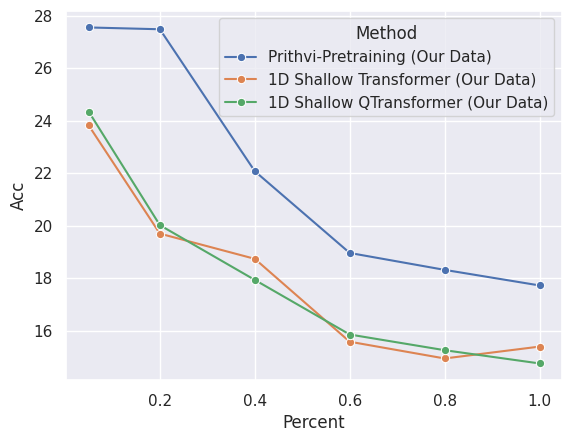

In [11]:
methods = [] 
for percent in [0.05, 0.2, 0.4, 0.6, 0.8, 1.0]: 
    for region in ["all"]:
        methods.append(f"Prithvi-Pretraining (Our Data),{percent},{region}")
        methods.append(f"1D Shallow Transformer (Our Data),{percent},{region}")
        methods.append(f"1D Shallow QTransformer (Our Data),{percent},{region}")

avg_results = print_avg_results(methods)
avg_results = pd.DataFrame(avg_results)

print(avg_results)
sns.lineplot(x="Percent", y="Acc", data=avg_results, hue="Method", marker="o")
plt.show()


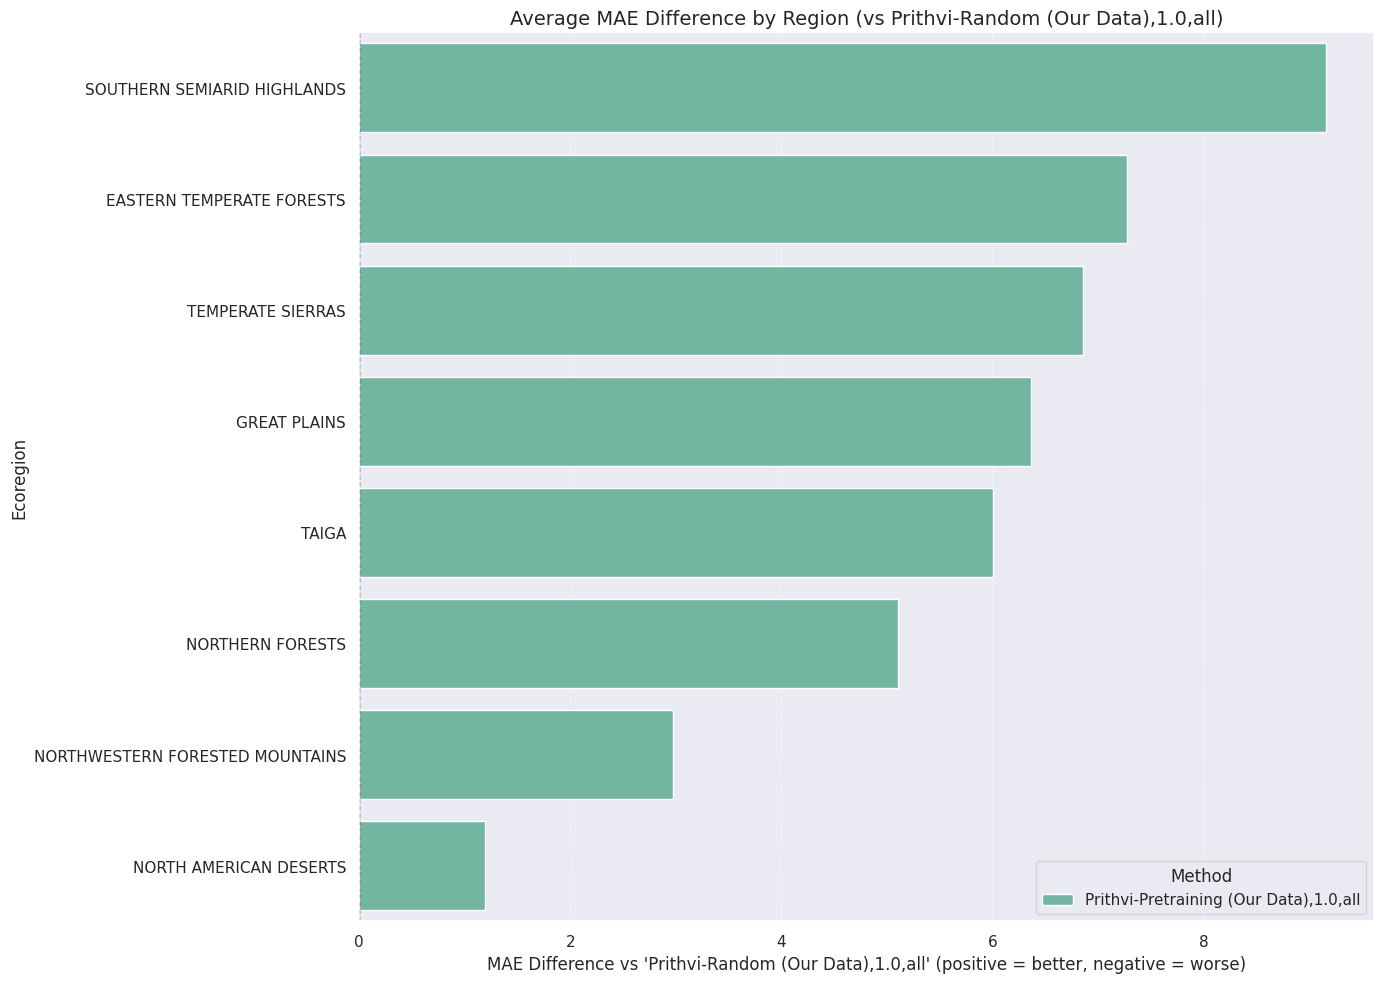

In [8]:
results_mae_map = results_mae.copy()
plot_mae_improvement_by_region(
    results_mae_map,
    geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
    eco_path="useco1/NA_CEC_Eco_Level1.shp",
    methods_to_compare=["Prithvi-Pretraining (Our Data),1.0,all"],
    anchor_method="Prithvi-Random (Our Data),1.0,all",
    figsize=(14, 10)
)

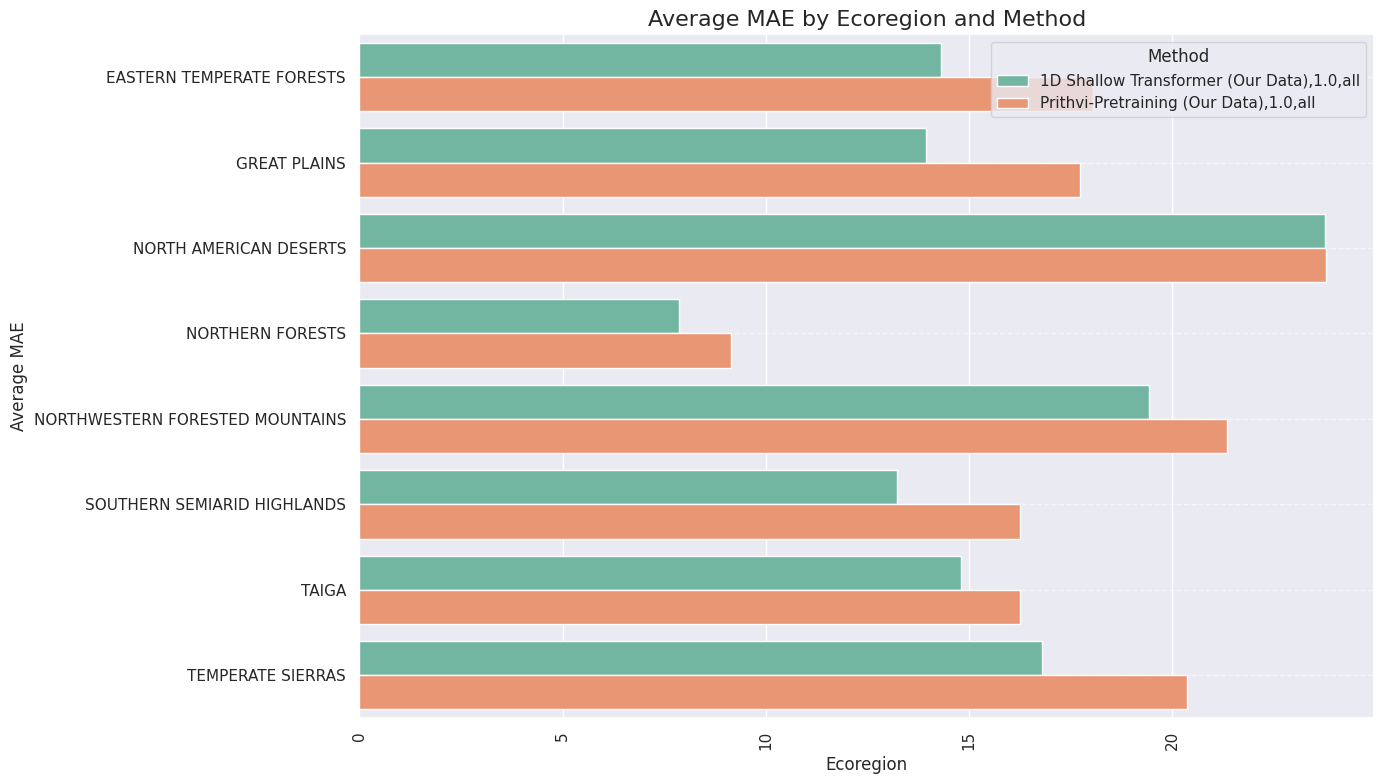

In [9]:
results_mae_map = results_mae.copy()
plot_methods_regions(results_mae_map, methods=["1D Shallow Transformer (Our Data),1.0,all", "Prithvi-Pretraining (Our Data),1.0,all"])

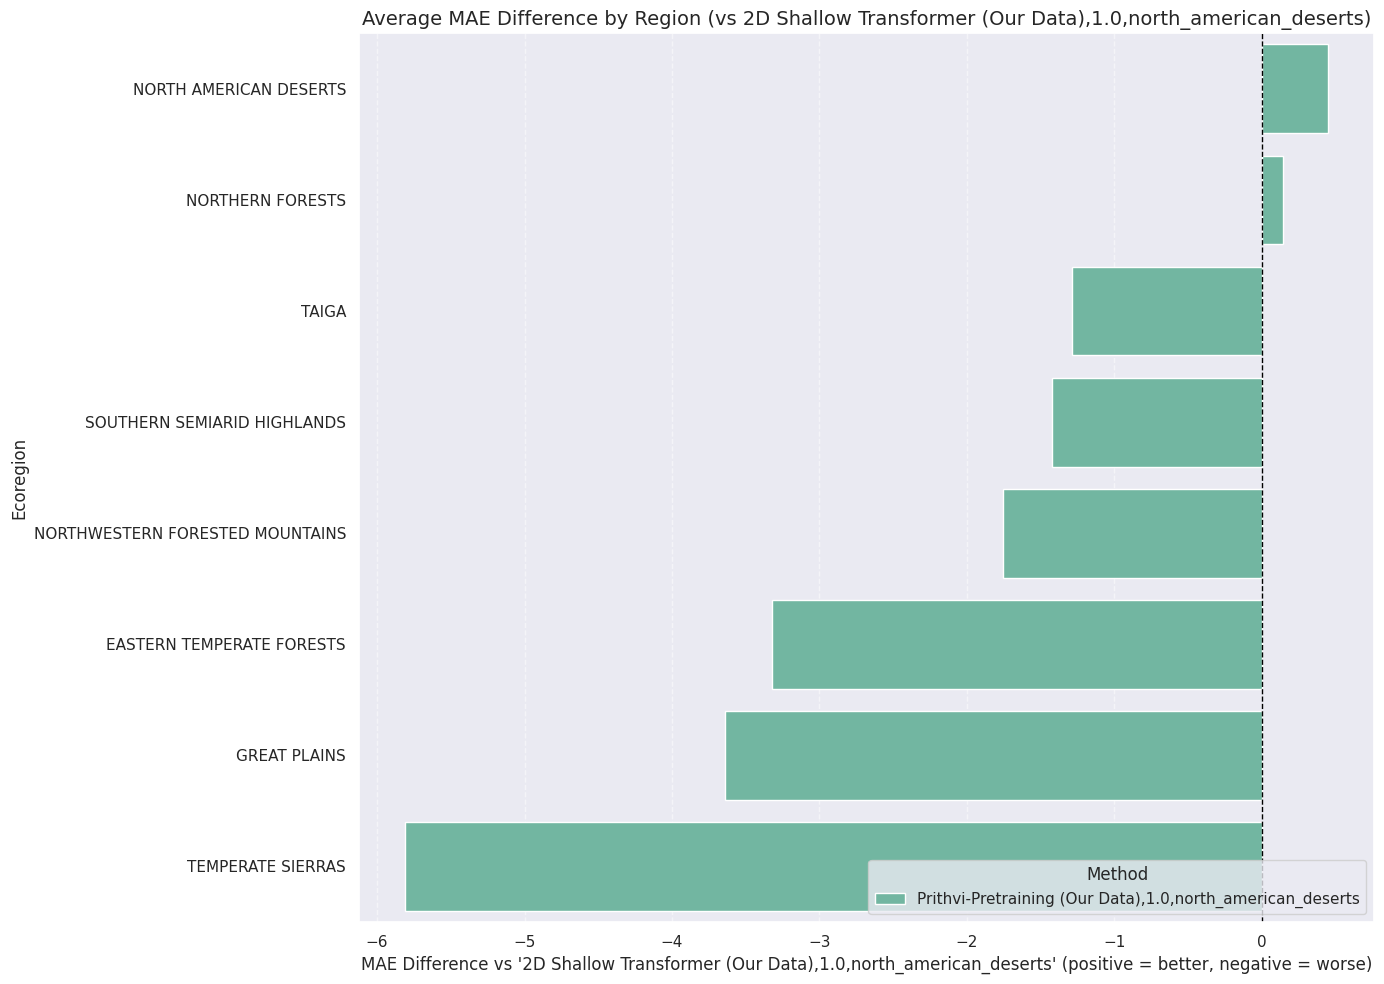

In [ ]:
results_mae_map = results_mae.copy()
plot_mae_improvement_by_region(
    results_mae_map,
    geo_path="/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson",
    eco_path="useco1/NA_CEC_Eco_Level1.shp",
    methods_to_compare=["Prithvi-Pretraining (Our Data),1.0,north_american_deserts"],
    anchor_method="1D Shallow Transformer (Our Data),1.0,north_american_deserts",
    figsize=(14, 10)
)

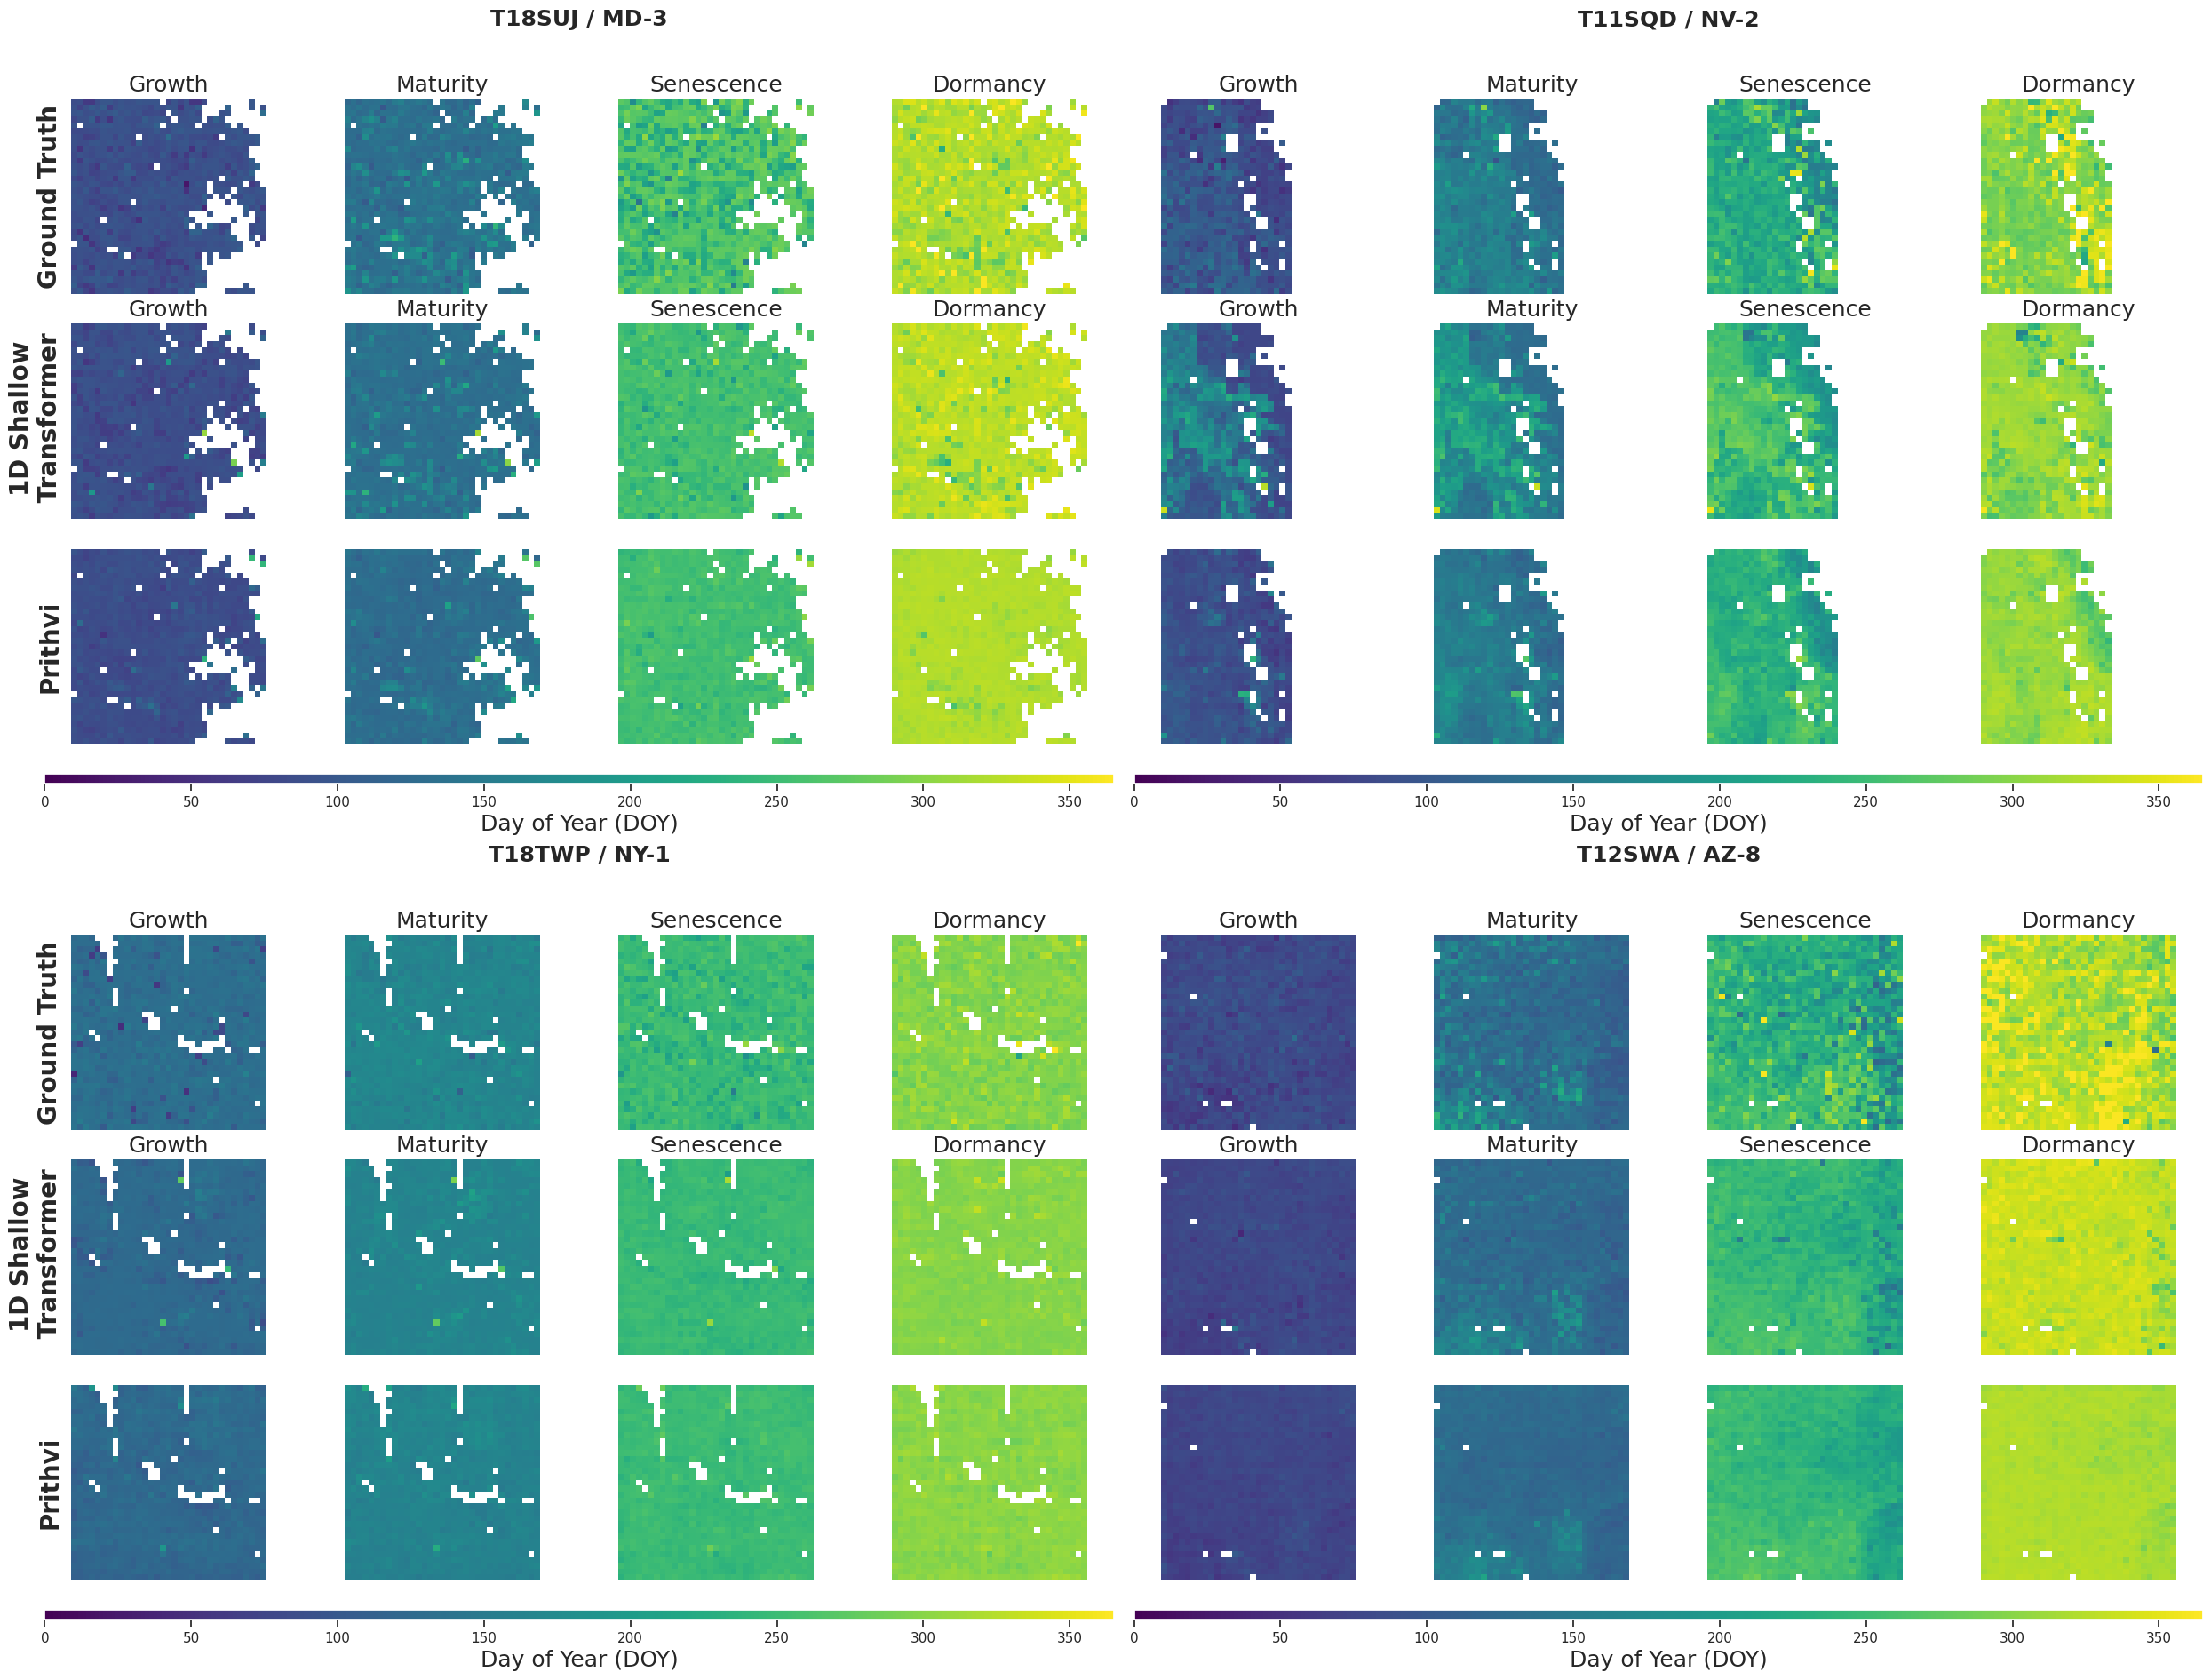

In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# ==== CONFIG ====
title_fontsize = 18
label_fontsize = 18
band_fontsize = 18
model_fontsize = 20
random_seed = 120
# ==== LOAD DATA ====
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

prithvi_pretraining = all_methods_final["Prithvi-Pretraining (Our Data),1.0,all"]
transformer_lsp = all_methods_final["1D Shallow Transformer (Our Data),1.0,all"]

# ==== SAMPLE 4 RANDOM TILE-SITE COMBOS ====
pairs = prithvi_pretraining[["HLStile", "SiteID"]].drop_duplicates()
sampled_pairs = pairs.sample(n=4, random_state=random_seed).reset_index(drop=True)

# ==== HELPER ====
def reshape_doy(df, hlstile, siteid, band):
    subset = df[(df["HLStile"] == hlstile) & (df["SiteID"] == siteid)]
    image = np.full((33, 33), np.nan)
    for _, row in subset.iterrows():
        r = int(row["row"] // 10)
        c = int(row["col"] // 10)
        image[r, c] = row[f"{band}_pred_DOY"]
    return image

def reshape_doy_truth(df, hlstile, siteid, band):
    subset = df[(df["HLStile"] == hlstile) & (df["SiteID"] == siteid)]
    image = np.full((33, 33), np.nan)
    for _, row in subset.iterrows():
        r = int(row["row"] // 10)
        c = int(row["col"] // 10)
        image[r, c] = row[f"{band}_truth_DOY"]
    return image

# Expand band codes
band_labels = {
    "G": "Growth",
    "M": "Maturity",
    "S": "Senescence",
    "D": "Dormancy"
}

# ==== PLOTTING ====
fig, axs = plt.subplots(2, 2, figsize=(28, 20))

for idx, (hlstile, siteid) in sampled_pairs.iterrows():
    outer_row = idx // 2
    outer_col = idx % 2
    outer_ax = axs[outer_row, outer_col]

    # print(outer_col)

    # Create 2x4 subgrid inside each 2x2 tile panel
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    gs_sub = GridSpecFromSubplotSpec(4, 4, subplot_spec=outer_ax.get_subplotspec(), 
                                    wspace=0.1, hspace=0.2, height_ratios=[1, 1, 1, 0.05])


    tile_geom = geo_data[(geo_data["HLStile"] == hlstile) & (geo_data["SiteID"] == siteid)]
    if tile_geom.empty:
        print(f"Skipping {hlstile}-{siteid} (no geometry)")
        continue

    # Draw model label once per row (left side)
    outer_ax.axis('off')
    outer_ax.text(0.5, 1.1, f"{hlstile} / {siteid}",
                  transform=outer_ax.transAxes, ha='center', va='bottom',
                  fontsize=title_fontsize, weight='bold')

    # === Loop over bands as before ===
    for i, band in enumerate(["G", "M", "S", "D"]):


        ax_g = fig.add_subplot(gs_sub[0, i])
        img_g = reshape_doy_truth(transformer_lsp, hlstile, siteid, band)
        im = ax_g.imshow(img_g, cmap="viridis", vmin=0, vmax=365)
        ax_g.set_title(band_labels[band], fontsize=band_fontsize)
        ax_g.axis('off')

        # Transformer row
        ax_t = fig.add_subplot(gs_sub[1, i])
        img_t = reshape_doy(transformer_lsp, hlstile, siteid, band)
        im = ax_t.imshow(img_t, cmap="viridis", vmin=0, vmax=365)
        ax_t.set_title(band_labels[band], fontsize=band_fontsize)
        ax_t.axis('off')

        # Prithvi row
        ax_p = fig.add_subplot(gs_sub[2, i])
        img_p = reshape_doy(prithvi_pretraining, hlstile, siteid, band)
        ax_p.imshow(img_p, cmap="viridis", vmin=0, vmax=365)
        ax_p.axis('off')

        if i == 0 and outer_col == 0:
            
            ax_g.text(-2, img_g.shape[0] // 2, "Ground Truth", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_g.transData, weight='bold')
            ax_t.text(-2, img_t.shape[0] // 2, "1D Shallow \n Transformer", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_t.transData, weight='bold')
            ax_p.text(-2, img_p.shape[0] // 2, "Prithvi", fontsize=model_fontsize,
                    ha="right", va="center", rotation=90, transform=ax_p.transData, weight='bold')

    # === Add per-grid colorbar (bottom row) ===
    cax_sub = fig.add_subplot(gs_sub[3, :])  # Bottom row, span all 4 columns
    cbar = fig.colorbar(im, cax=cax_sub, orientation="horizontal")
    cbar.set_label("Day of Year (DOY)", fontsize=label_fontsize)


plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


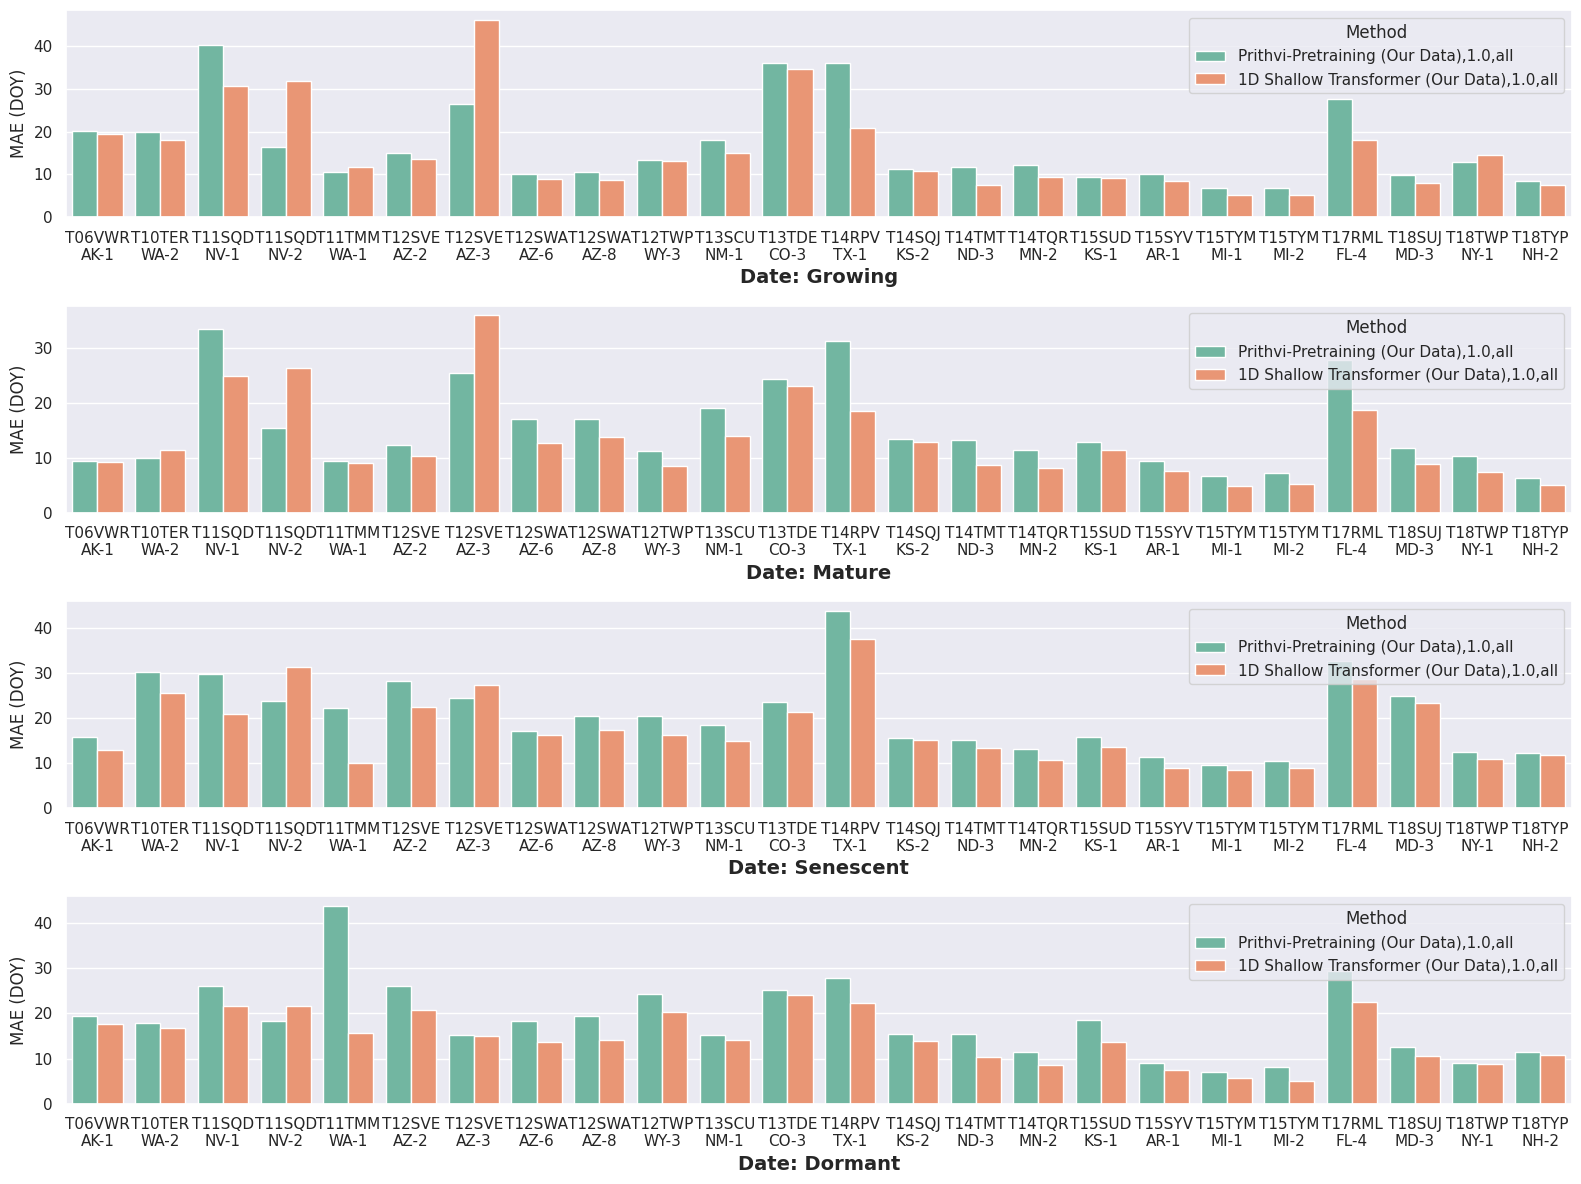

In [11]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


methods = ["Prithvi-Pretraining (Our Data),1.0,all", "1D Shallow Transformer (Our Data),1.0,all"]
results_mae_bar = results_mae[results_mae["Method"].isin(methods)].copy()

date_to_rename = {
    "G": "Growing",
    "M": "Mature",
    "S": "Senescent",
    "D": "Dormant",
    "Mean": "Mean"
}


#create a new column that combines HLStile and SiteID seperated by \n 
results_mae_bar["Hlstile_SiteID"] = results_mae_bar["HLStile"] + "\n" + results_mae_bar["SiteID"]


#fig with 4 subplots vertical 
fig, axs = plt.subplots(4, 1, figsize=(16, 12))
for idx, date in enumerate(["G", "M", "S", "D"]):
    results_plot_date = results_mae_bar[results_mae_bar["Date"] == date]
    sns.barplot(data=results_plot_date, x="Hlstile_SiteID", y="MAE", hue="Method", palette="Set2", ax=axs[idx])
    # axs[idx].set_title(f"MAE per HLStile for {date} by Method", fontsize=16)
    #make xlabel bold
    axs[idx].set_xlabel(f"Date: {date_to_rename[date]}", fontsize=14, fontweight='bold')
    axs[idx].set_ylabel("MAE (DOY)")
    axs[idx].legend(title="Method", loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import cartopy.io.shapereader as shpreader
import matplotlib.patheffects as pe

# === Load Data ===
results_mae_map = results_mae.copy()
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

train_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_train_samples.csv")
train_df = train_df[train_df["version"] == "v1"]
train_df = train_df.rename(columns={"tile": "HLStile"})

test_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_test_samples.csv")
test_df = test_df[test_df["version"] == "v1"]
test_df = test_df.rename(columns={"tile": "HLStile"})

# Prepare HLStile names for joining
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data["centroid"] = geo_data.geometry.centroid

# === Compute Improvements ===
methods = ["Transformer-LSP (Our Data) 0.6", "Prithvi-Pretraining (Our Data) 0.6"]
mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

mae_summary = (
    mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
    .mean()
    .unstack()
    .dropna()
)
mae_summary["MAE_diff"] = (
    mae_summary["Transformer-LSP (Our Data) 0.6"]
    - mae_summary["Prithvi-Pretraining (Our Data) 0.6"]
)
mae_summary = mae_summary[mae_summary["MAE_diff"] > 0].reset_index()

# Join with tile centroids
mae_summary = mae_summary.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_improve = gpd.GeoDataFrame(mae_summary, geometry="centroid", crs=geo_data.crs)

# === Training/Test Sites ===
train_pairs = train_df[["HLStile", "SiteID"]].drop_duplicates()
train_pairs = train_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_train = gpd.GeoDataFrame(train_pairs, geometry="centroid", crs=geo_data.crs)

test_pairs = test_df[["HLStile", "SiteID"]].drop_duplicates()
test_pairs = test_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_test = gpd.GeoDataFrame(test_pairs, geometry="centroid", crs=geo_data.crs)

# === US State Borders via Cartopy Natural Earth ===
shpfilename = shpreader.natural_earth(
    resolution="110m", category="cultural", name="admin_1_states_provinces"
)
us_states = gpd.read_file(shpfilename)
us_states = us_states[us_states["admin"] == "United States of America"]
us_states = us_states.to_crs(epsg=3857)

# === Plot ===
fig, ax = plt.subplots(figsize=(18, 10))

# Red circles (improvements)
gdf_improve.plot(
    ax=ax,
    markersize=gdf_improve["MAE_diff"] * 60,
    alpha=0.5,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
    zorder=3,
    label="Improved Performance due to Training"
)

# Yellow Xs (training)
gdf_train.plot(
    ax=ax,
    color="yellow",
    marker="x",
    markersize=100,
    label="Training Sites",
    zorder=3
)

# Orange circles (test)
gdf_test.plot(
    ax=ax,
    color="orange",
    marker="o",
    markersize=100,
    label="Test Sites",
    zorder=3
)

# Basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)

# State borders
us_states.boundary.plot(ax=ax, color="white", linewidth=1.0, zorder=4)

# State labels
for _, row in us_states.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row["name"],
        fontsize=8, color="white",
        ha="center", va="center", zorder=5,
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

# Zoom to continental US
ax.set_xlim(-14000000, -7000000)
ax.set_ylim(2500000, 6500000)

ax.axis("off")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


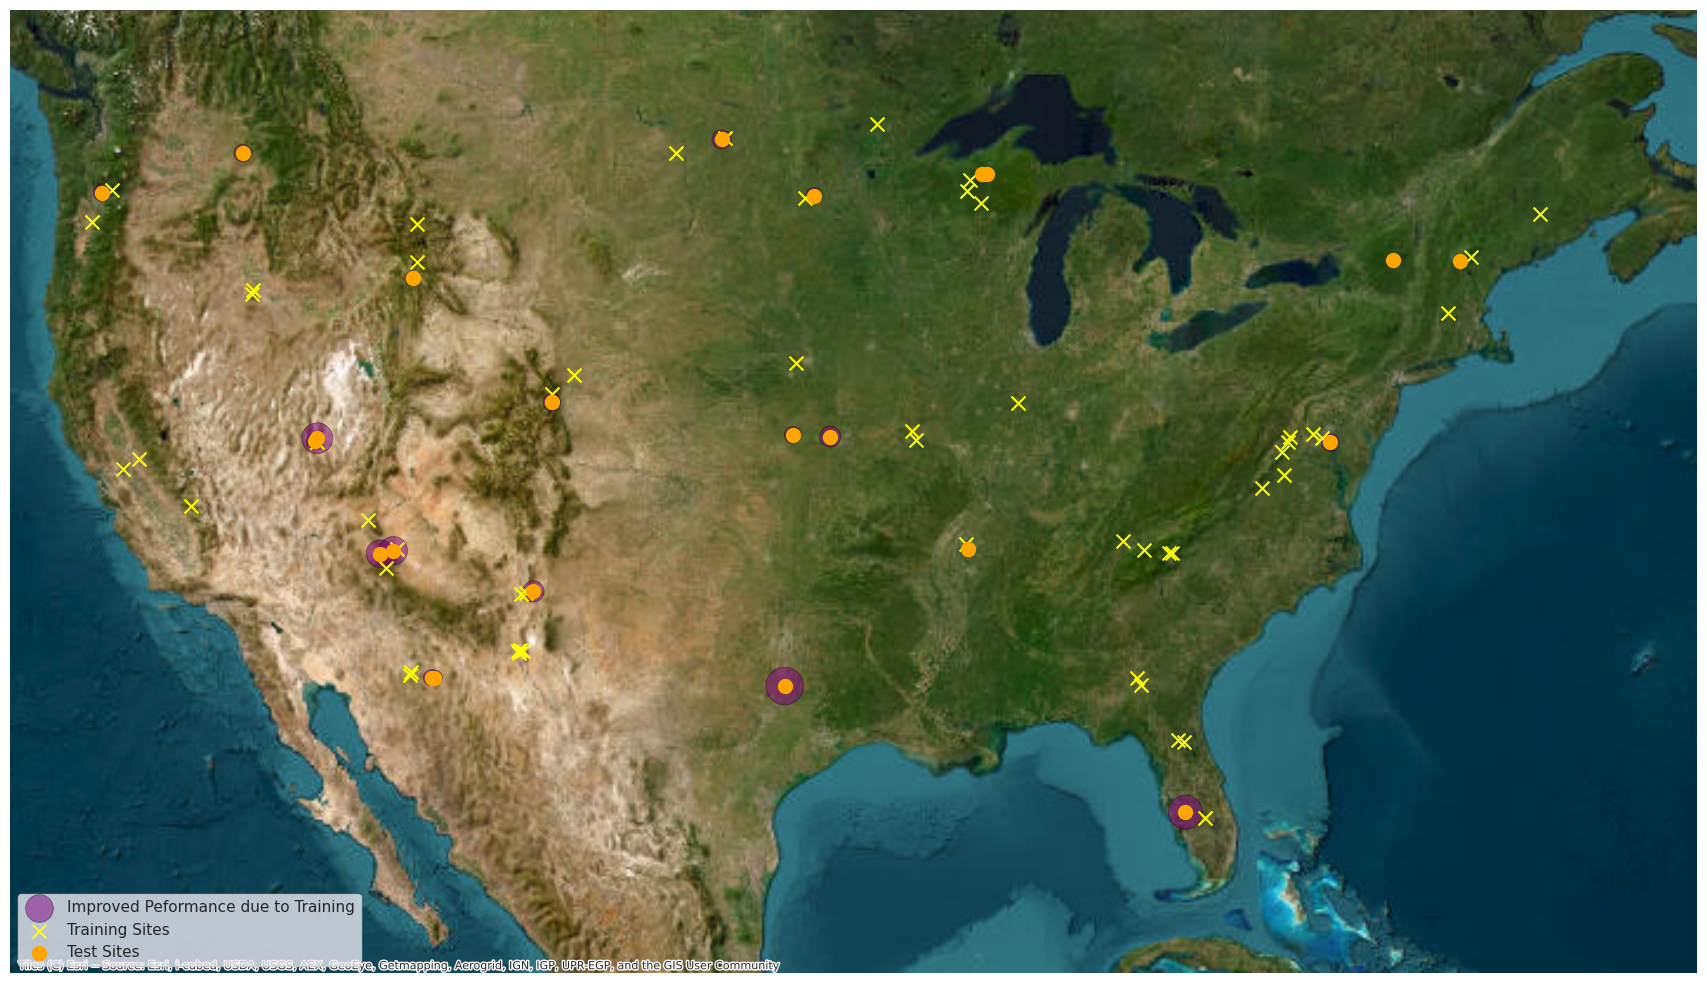

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

# Load data
results_mae_map = results_mae.copy()
geo_data = gpd.read_file("/projectnb/hlsfm/applications/lsp/ancillary/HP_LSP/geotiff_extents.geojson")
geo_data = geo_data.rename(columns={"Site_ID": "SiteID"})

train_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_train_samples.csv")
train_df = train_df[train_df["version"] == "v1"]  # Filter out rows with NaN HLStile
train_df = train_df.rename(columns={"tile": "HLStile"})

test_df = pd.read_csv("/usr4/cs505/mqraitem/ivc-ml/geo/data/LSP_test_samples.csv")
test_df = test_df[test_df["version"] == "v1"]  # Filter out rows with NaN HLStile
test_df = test_df.rename(columns={"tile": "HLStile"})

# Prepare HLStile names for joining
geo_data["HLStile"] = "T" + geo_data["name"]
geo_data = geo_data.set_crs("EPSG:4326").to_crs(epsg=3857)
geo_data["centroid"] = geo_data.geometry.centroid

# === RED CIRCLES: Where Pretraining Improves ===

# Compute average MAE per (HLStile, SiteID, Method)
methods = ["Transformer-LSP (LSP Data)", "Prithvi-Pretraining (Our Data)"]
mae_filtered = results_mae_map[results_mae_map["Method"].isin(methods)]

mae_summary = (
    mae_filtered.groupby(["HLStile", "SiteID", "Method"])["MAE"]
    .mean()
    .unstack()
    .dropna()
)

mae_summary["MAE_diff"] =  mae_summary["Prithvi-Pretraining (Our Data)"] - mae_summary["Transformer-LSP (LSP Data)"] 
mae_summary = mae_summary[mae_summary["MAE_diff"] > 0].reset_index()

# Join with tile centroids
mae_summary = mae_summary.merge(geo_data[["HLStile", "SiteID", "centroid"]], on=["HLStile", "SiteID"], how="left")
gdf_improve = gpd.GeoDataFrame(mae_summary, geometry="centroid", crs=geo_data.crs)

# === YELLOW Xs: Training tile-site pairs ===
train_pairs = train_df[["HLStile", "SiteID"]].drop_duplicates()
train_pairs = train_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)
gdf_train = gpd.GeoDataFrame(train_pairs, geometry="centroid", crs=geo_data.crs)

test_pairs = test_df[["HLStile", "SiteID"]].drop_duplicates()
test_pairs = test_pairs.merge(
    geo_data[["HLStile", "SiteID", "centroid"]],
    on=["HLStile", "SiteID"],
    how="left"
)

gdf_test = gpd.GeoDataFrame(test_pairs, geometry="centroid", crs=geo_data.crs)

# === Plot ===
fig, ax = plt.subplots(figsize=(18, 10))

# Basemap

# Red circles (improvements)
gdf_improve.plot(
    ax=ax,
    markersize=gdf_improve["MAE_diff"] *60,
    alpha=0.5,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
    zorder=3,
    label="Improved Peformance due to Training"
)

# Yellow Xs (training tiles)
gdf_train.plot(
    ax=ax,
    color="yellow",
    marker="x",
    markersize=100,
    label="Training Sites",
    zorder=3
)

gdf_test.plot(
    ax=ax,
    color="orange",
    marker="o",
    markersize=100,
    label="Test Sites",
    zorder=3
)

cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)
ax.set_xlim(-14000000, -7000000)
ax.set_ylim(2500000, 6500000)


ax.axis('off')
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Mapping from state abbreviations to full names (matching the GeoJSON)
state_abbrev = {
    'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado',
    'CT':'Connecticut','DE':'Delaware','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho',
    'IL':'Illinois','IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan','MN':'Minnesota',
    'MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada',
    'NH':'New Hampshire','NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina',
    'ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas',
    'UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington','WV':'West Virginia',
    'WI':'Wisconsin','WY':'Wyoming'
}

def plot_state_points(state_list):
    # Strip numbers and deduplicate
    abbrevs = set(s.split('-')[0] for s in state_list)
    full_names = [state_abbrev[a] for a in abbrevs if a in state_abbrev]

    # Load a reliable GeoJSON of US states
    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    states = gpd.read_file(url)

    # Filter selected states
    selected = states[states['name'].isin(full_names)]

    # Plot US outline
    fig, ax = plt.subplots(figsize=(12,8))
    states.boundary.plot(ax=ax, linewidth=0.5, color="gray")
    selected.plot(ax=ax, color="lightblue", edgecolor="black")

    # Compute and plot centroids
    centroids = selected.geometry.centroid
    plt.scatter(centroids.x, centroids.y, color="red", zorder=5)

    # Label each state
    for name, (x,y) in zip(selected['name'], zip(centroids.x, centroids.y)):
        plt.text(x, y, name, fontsize=8, ha='center')

    plt.title("US States with Points at Centroids")
    plt.show()

/scratch/ipykernel_2805035/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


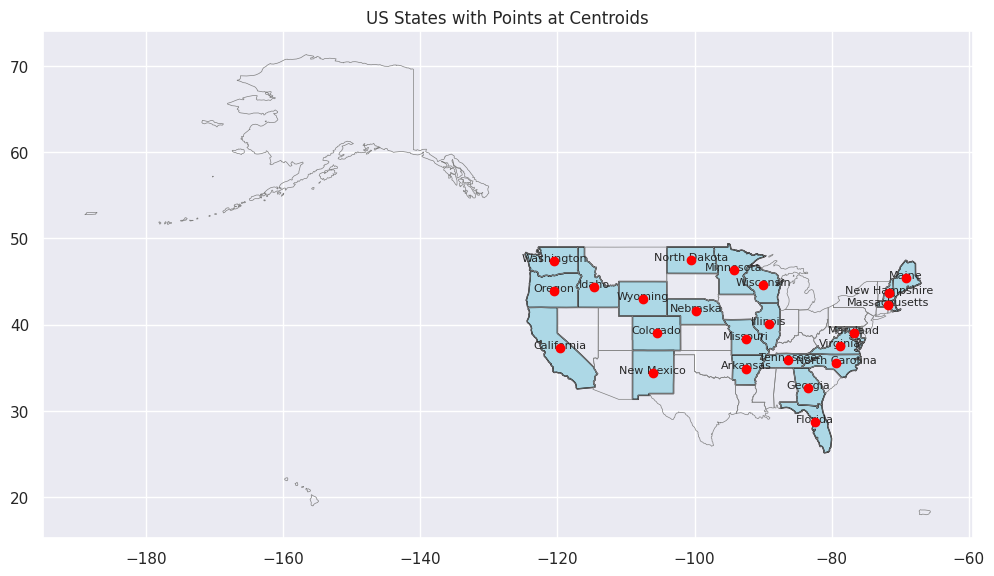

In [ ]:
samples_states = open("states_1.0_training.txt", "r").read().splitlines()
plot_state_points(samples_states)


/scratch/ipykernel_405728/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


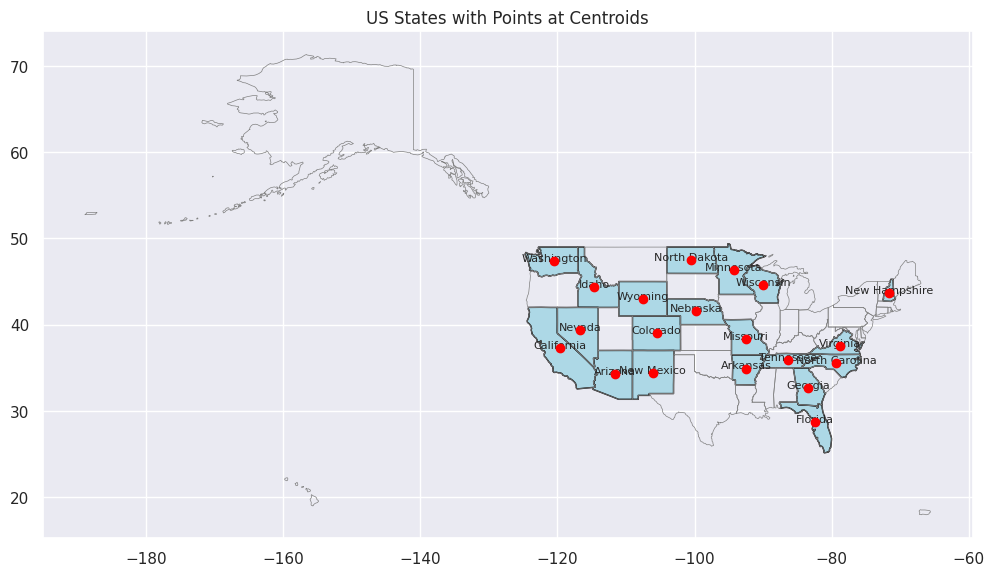

In [ ]:
samples_states = open("states_0.6.txt", "r").read().splitlines()
plot_state_points(samples_states)


/scratch/ipykernel_405728/51601335.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = selected.geometry.centroid


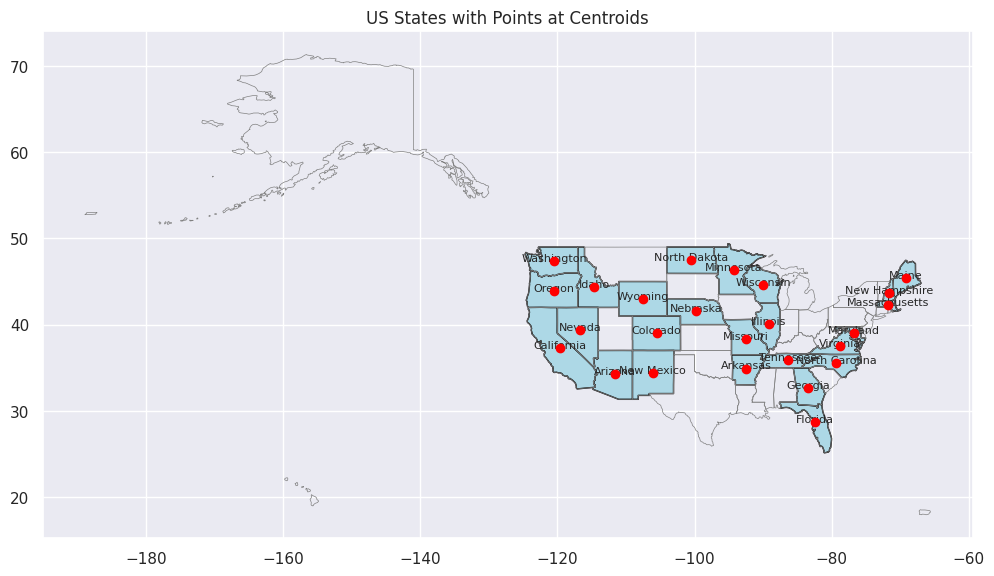

In [ ]:
samples_states = open("states_0.95.txt", "r").read().splitlines()
plot_state_points(samples_states)